# Detekcja maków na zdjęciach
W tym zadaniu przedstawimy przykład metody, która pozwala na wykrycie oznaczenie położenia maków na zdjęciu. W zadaniu przejdziemy po kolei przez to jak komputer "rozumie" obraz, następnie rozważymy najprostszą metodę detekcji obrazu w oparciu o kolor elementu - w przypadku maków czerwony. Następnie sprawdzimy, w jaki sposób sieć neuronowa może pomóc nam poprawić pewność wykrycia maku na obrazku. Na koniec porównamy obie metody, zauważając zarówno ich zalety jak i wady. Przedyskutujemy również kolejne kroki, które mogłyby dalej poprawić trafność wykrycia maków na zdjęciu

In [1]:
"""
Załadowanie bibliotek wykorzystywanych w zadaniu
"""

import os
import json
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from scipy import ndimage
tf.keras.utils.set_random_seed(42)

2023-09-19 08:23:47.844280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-19 08:23:47.844335: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
"""
Wczytanie danych - zdjęcia podzielone na trzy części - treningową, walidacyjną (testową) 
oraz na uzupełnienie zbioru treningowego
"""
df_test = pd.read_csv('path_to_files.csv')
df_test.dataset.value_counts()

train    26
final    11
val      11
Name: dataset, dtype: int64

## Jak "widzi" komputer?

Komputer potrafi wyświetlać całą paletę barw, jednak w jaki sposób to robi? Jedną z metod przedstawienia kolorów jest tzw. model RGB (z angielskiego Red-Green_Blue), który przedstawia zdjęcie w formie trzech reprezentacji - intensywności koloru czerwonego, zielonego oraz niebieskiego. Sumarycznie intensywność każdego z kanałów koloru przekłada się na to, co widzimy na monitorze. Tam, gdzie intensywność w każdym kanale będzie wysoka, będziemy widzieli kolor biały. I podobnie tam, gdzie intensywność każdego koloru w kanałach będzie niska, będziemy widzieli kolor czarny. Pozostałe kolory otrzymujemy jako mieszankę różnych intensywności czerwonego, zielonego i niebieskiego, podobnie jak na palecie malarskiej. 

Jak w tej reprezentacji otrzymać np. kolor żółty? Możesz sprawdzić tu: 
- https://www.w3schools.com/colors/colors_rgb.asp

Poniżej wykorzystamy funkcję plot_image_and_channels by zobaczyć jak wygląda przedstawienie zdjęcia w każdym z trzech kolorowych kanałów:

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def read_image(df, frame):
    
    img = Image.open(df.path.iloc[frame]).convert('RGB')
    img = np.array(img)
    
    return img

def plot_image_and_channels(img):
    color_r = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
    cmap_r = LinearSegmentedColormap.from_list("Custom", color_r, N=255)
    color_g = [(0, 0, 0), (0, 1, 0)] # first color is black, last is green
    cmap_g = LinearSegmentedColormap.from_list("Custom", color_g, N=255)
    color_b = [(0, 0, 0), (0, 0, 1)] # first color is black, last is blue
    cmap_b = LinearSegmentedColormap.from_list("Custom", color_b, N=255)
    _, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
    ax[0,0].imshow(img)
    ax[0,0].set_title('original image')
    ax[0,1].imshow(img[:,:,0], cmap=cmap_r, vmin=0, vmax=255)
    ax[0,1].set_title('red channel')
    ax[1,0].imshow(img[:,:,1], cmap=cmap_g, vmin=0, vmax=255)
    ax[1,0].set_title('green channel')
    ax[1,1].imshow(img[:,:,2], cmap=cmap_b, vmin=0, vmax=255)
    ax[1,1].set_title('blue channel')

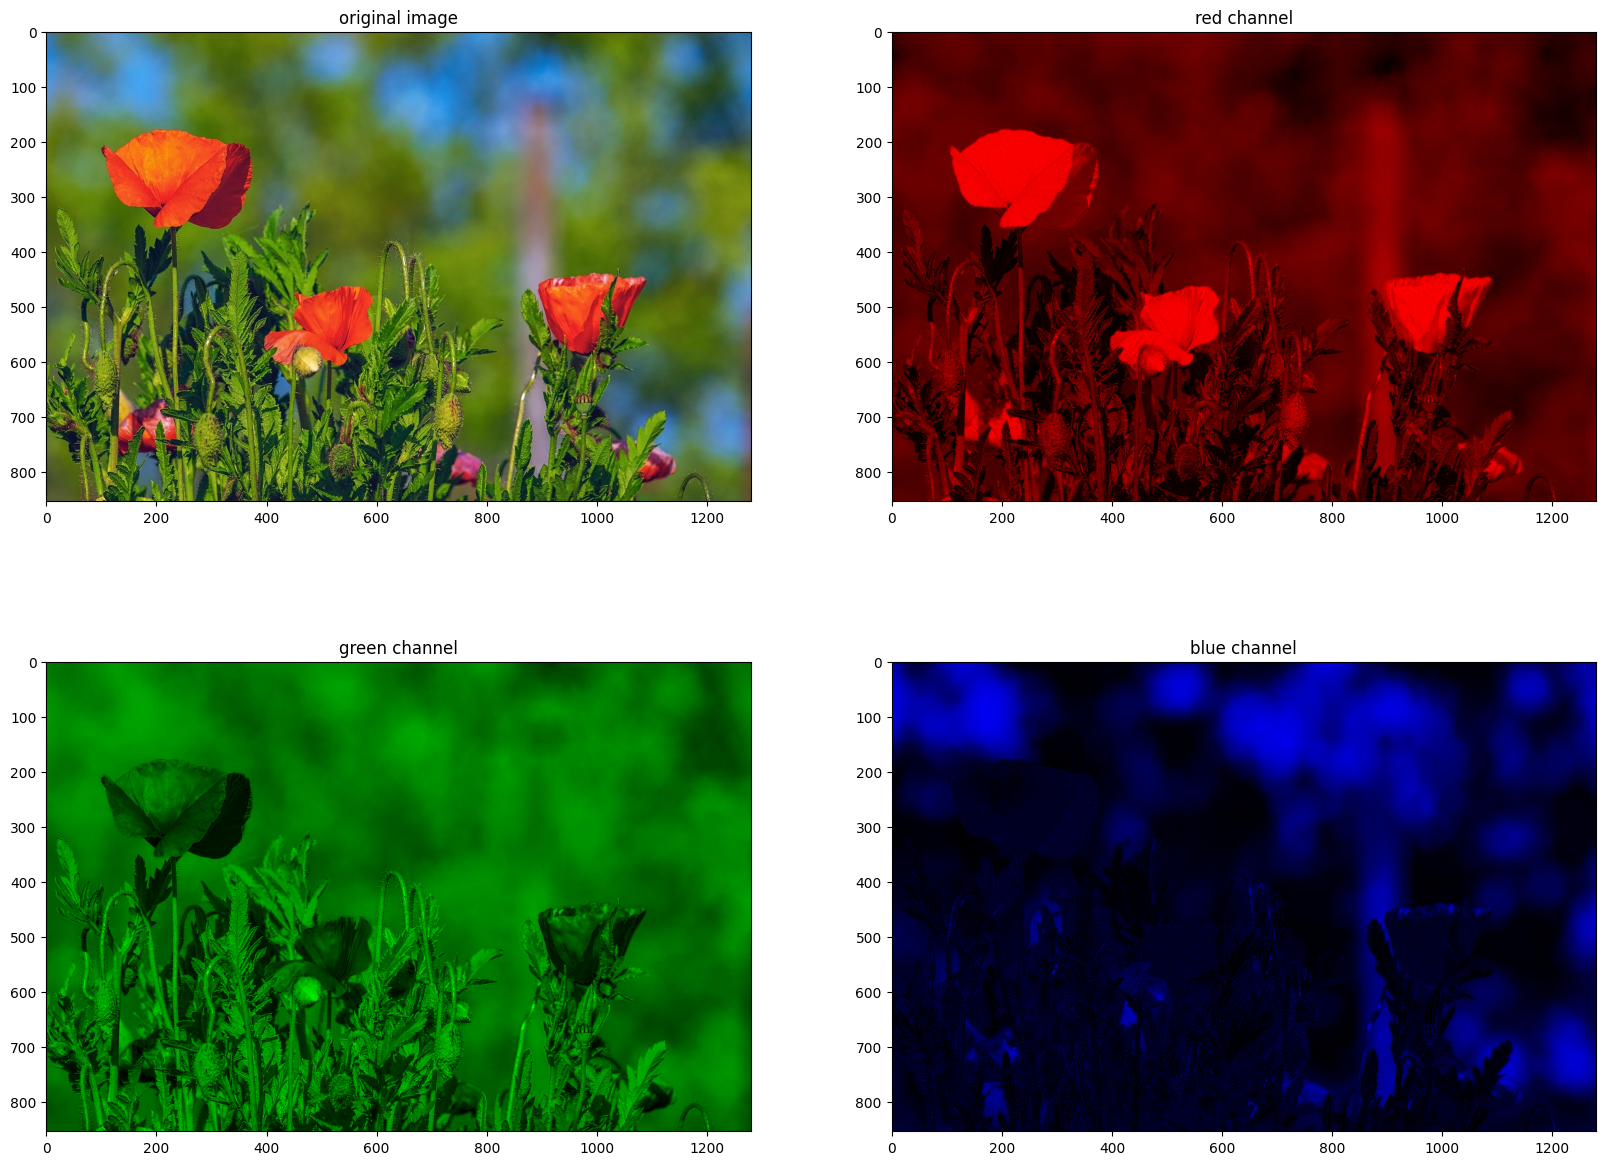

In [5]:
"""
Sprawdź dla zdjęć z zakresu wartości im_num 22-47
"""
im_num = 28
img = read_image(df_test, im_num)
plot_image_and_channels(img)

## Wykrycie elementu na zdjęciu
Jak widzimy, każdy obszar na zdjęciu możemy opisać jako intensywność każdego z kanałów RGB. Mieliśmy okazję sprawdzić również jak otrzymujemy kolory w zapisie RGB. Teraz w jaki sposób możemy wykryć maki na zdjęciu? Są czerwone, to oznacza, że powinniśmy poszukać dużej intensywności koloru w kanale czerwonym i stosunkowo niskiej intensywności w kanałach zielonym i niebieskim. Sprawdźmy to:

In [6]:
def small_cluster_filter(mask, area_percent):
    
    min_area = mask.shape[0] * mask.shape[1] * area_percent
    label_temp, _ = ndimage.label(mask)
    series_counts = pd.Series(np.array(label_temp).flatten()).value_counts().drop(0)
    filtered_points = series_counts[series_counts.values > min_area]
    mod_mask = np.array(label_temp)
    mod_mask = np.isin(mod_mask, filtered_points.index)

    return mod_mask.astype(np.uint8)

def mask_red_regions(img, red, green, blue, area_percent, k_dilate=3):
    # scale colors from fraction to real value
    mask = (np.where(img[:, :, 0] > red * 255, 1, 0) * np.where(img[:, :, 1] < green * 255, 1, 0) * \
           np.where(img[:, :, 2] < blue * 255, 1, 0)).astype(np.uint8)
    kernel = np.ones((k_dilate, k_dilate)).astype(np.uint8)
    mask = cv2.dilate(mask, kernel)
    mask = small_cluster_filter(mask, area_percent)
    mask = np.expand_dims(mask, -1)
    
    return mask

def plot_image_and_mask(img, mask):
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
    ax[0].imshow(img)
    ax[0].set_title('original image')
    ax[1].imshow(img * mask)
    ax[1].set_title('masked image')

Poniżej wczytujemy zdjęcie, a następnie zachowujemy tylko te elementy, które mają intensywność (w skali 0-1)
przynajmniej tyle, co pod wartością red dla koloru czerwonego, oraz maksymalnie tyle, co pod wartościami
green dla zielonego i blue dla niebieskiego. Dodatkowo zostały dodane dwa elementy dla poprawy jakości wykrycia:

k_dilate - o ile pogrubić początkowo wykryte obszary; taki zabieg pozwala łączyć rejony, które są rozdzielone 
przez np. jasną smugę, źdźbło trawy czy inne elementy, które mogą przysłonić kwiat maku

area_percent - czyli jaki jest minimalny rozmiar obszaru (w proporcji do rozmiaru zdjęcia), by zostać 
przedstawionym. To pomaga usunąć pojedyncze piksele, które przypadkowo akurat spełniły nasze kryterium. Dzięki 
temu mamy mniej niepoprawnych wykryć.

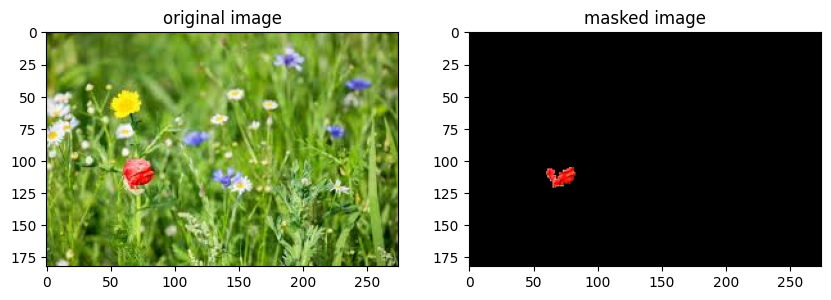

In [7]:
img = read_image(df_test, 21)
mask = mask_red_regions(img, red=0.75, green=0.23, blue=0.23, area_percent=0.002, k_dilate=3)
plot_image_and_mask(img, mask)

## Przygotowanie pierwszych detekcji

Otrzymaliśmy pierwszy algorytm do wykrywania maków. Sprawdźmy, jak sobie radzi na zdjęciach!

Poniżej mamy funkcje, które pozwalają nam opisać pudełko naokoło wykrytych regionów. Pozwalają też je wyświetlić w formie obrazka. Sprawdźmy, jak wyglądają nasze wykrycia i jak odnoszą się do przygotowanego manualnie opisu zdjęć

In [8]:
"""
Wczytujemy manualny opis zdjęć
"""

with open('annotations.json') as f:
    annotations = json.load(f)

In [9]:
def get_bboxes_from_mask(mask, increment=0.02):

    label_to_box, _ = ndimage.label(mask)
    x_incr = int(mask.shape[0] * increment)
    y_incr = int(mask.shape[1] * increment)
    clusters = np.delete(np.unique(label_to_box), 0)
    bboxes = []
    for label in clusters:
        temp_mask = np.where(label_to_box == label)
        bbox = [np.min(temp_mask[0])-x_incr, np.max(temp_mask[0])+x_incr, np.min(temp_mask[1]) \
                - y_incr, np.max(temp_mask[1]) + y_incr] 
        bboxes.append(bbox)

    return bboxes
    
def convert_bboxes(bboxes):
    
    new_bboxes = []
    for bbox in bboxes:
        cv_bbox = np.array([[bbox[2], bbox[0]],[bbox[2], bbox[1]], [bbox[3], bbox[1]], [bbox[3], bbox[0]]]).astype(int)
        new_bboxes.append(cv_bbox)
        
    return new_bboxes

def visualise_contours(img, bboxes):
    draw_img = img.copy()
    for bbox in bboxes:
        draw_img = cv2.drawContours(img,[bbox],0,(0,0,255),4)
    plt.imshow(draw_img)

In [10]:
"""
Wykonujemy przewidywanie dla wszystkich zdjęć ze zbioru. Nasze wykrycia zapiszemy jako prostokąty, 
które będzie można będzie narysować na zdjęciu.
"""

bboxes_for_images = {}
for i in range(df_test.shape[0]):
    img = read_image(df_test, i)
    mask = mask_red_regions(img, red=0.75, green=0.23, blue=0.23, area_percent=0.002, k_dilate=3)
    bboxes = get_bboxes_from_mask(mask, increment=0.02)
    bboxes_for_images[i] = bboxes

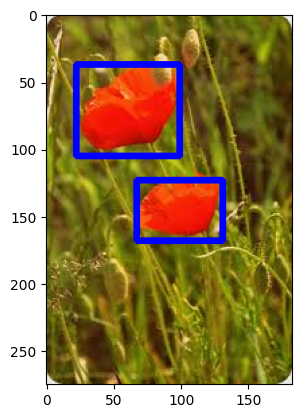

In [11]:
"""
Sprawdź, jak wyglądają wykryte obszary naszym algorytmem! Sprawdźmy zdjęcia zarówno ze zbioru 
treningowego (22-47), jak i walidacyjnego (11-21)
"""
im_num = 25
img = read_image(df_test, im_num)
cv_bboxes = convert_bboxes(bboxes_for_images[im_num])
visualise_contours(img, cv_bboxes)

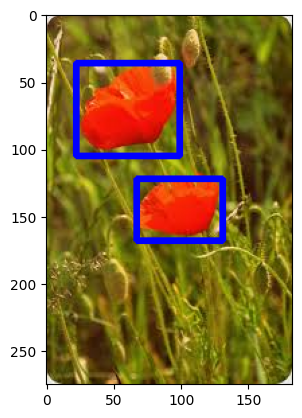

In [12]:
"""
Porównajmy, jak to samo wykrycie wygląda w przypadku manualnego oznaczenia maków:
"""
img = read_image(df_test, im_num)
cv_bboxes = convert_bboxes(annotations['{}'.format(im_num)])
visualise_contours(img, cv_bboxes)

## Sieć neuronowa
Wyniki wykrywania są niezłe, jednak sprawdzenie wyników wykrycia dla zbioru walidacyjnego odsłania poważną słabość naszego rozwiązania - wszystkie czerwone elementy są wykrywane, również te, które nie są makami! Czy masz pomysł na inne reguły, które pomogłyby nam wyróżnić maki od np. bluzki?

Jednym z narzędzi, które pozwala zidentyfikować takie reguły, są sieci neuronowe. Spróbujemy użyć sieci neuronowej, by ograniczyć liczbę niepoprawnych wykryć maków. Jak to zrobimy?

W pierwszym kroku będziemy najpierw szukali czerwonych elementów na obrazku - to na ten moment działało wystarczająco dobrze. W drugim kroku sieć oceni, czy wykryty czerwony obszar jest makiem. Taki problem nazywamy klasyfikacją binarną (są dwie opcje: albo coś jest, albo nie jest makiem). Wszystkie elementy, które sieć uzna za błędnie wykryte, odrzucimy. Dzięki temu wzrośnie nam pewność, że to, co wykryliśmy, jest faktycznie kwiatem, o który nam chodzi

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
"""
Definiujemy jak wygląda nasza sieć neuronowa. Zainteresowanych szczegółami zapraszam do zgłębiania roli
każdego z jej elementów w dokumentacji!
https://www.tensorflow.org/api_docs/python/tf/keras/layers
"""

model = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),  # 64x64 RGB images
        layers.Conv2D(filters=4, kernel_size=3, strides=2, padding='same', activation="relu"),
        layers.MaxPooling2D(2),
        layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation="relu"),
        layers.MaxPooling2D(2),
        layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation="relu"),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(1, name="layer3", activation='sigmoid'),
    ]
)

2023-09-19 08:53:30.705815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 08:53:30.706940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lukasz/miniconda3/envs/DSci/lib/python3.9/site-packages/cv2/../../lib64:
2023-09-19 08:53:30.707072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lukasz/miniconda3/envs/DSci/lib/python3.9/site-packages/cv2/../../lib64:
2023-09-19 08:53:30.707158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcub

In [19]:
"""
Przygotowujemy nasz model do treningu - definiujemy algorytm do nauki (optimizer),
w jaki sposób sieć ma się uczyć (loss) oraz metrykę sukcesu, którą możemy obserwować
w czasie treningu. Tutaj jest to dokładność (poprawność) klasyfikacji
"""

from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [20]:
"""
Tak wygląda nasz model na koniec procesu:
"""

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 4)         112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 16)          1168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 16)         0

### Przygotowanie danych do treningu sieci
Żeby sieć mogła się uczyć, to zdjęcia, które dostaje, musi otrzymywać zawsze w takim samym rozmiarze. Dzięki temu będzie mogła znaleźć podobne cechy obrazków, na których są maki, co pozwoli na poprawną klasyfikację naszych obszarów zainteresowania. Stąd poniżej przygotujemy dwa zestawy danych - te wykrycia, w których wybrany fragment nie zawiera maków oraz te fragmenty zdjęć na których znajdują się maki.

In [15]:
"""
Poszerzamy zbiór danych o zdjęcia bez maków
"""
root_dir = 'train_imgs'
os.mkdir(root_dir)
directory = os.path.join(root_dir, 'train_fails')
img_size = (64, 64)
os.mkdir(directory)
anno = 0
df_imgs_fail = []
for im_num in range(0, 11):
    img = read_image(df_test, im_num).astype(np.uint8)
    for bbox_num in range(len(bboxes_for_images[im_num])):
        bbox = bboxes_for_images[im_num][bbox_num]
        img_part = img[bbox[0]:bbox[1], bbox[2]:bbox[3]]
        res_img = cv2.resize(img_part, img_size, interpolation=cv2.INTER_AREA)
        save_path = os.path.join(directory, 'test_img_{}_{}.png'.format(im_num, bbox_num))
        cv2.imwrite(save_path, cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))
        df_imgs_fail.append({'path': save_path, 'class': anno})
df_imgs_fail = pd.DataFrame(df_imgs_fail)

In [16]:
"""
Fragmenty zdjęć zawierające maki z oryginalnego zbioru treningowego
"""
directory = os.path.join(root_dir, 'train_passes')
os.mkdir(directory)
anno = 1
df_imgs_pass = []
for im_num in range(22, 48):
    img = read_image(df_test, im_num).astype(np.uint8)
    for bbox_num in range(len(annotations['{}'.format(im_num)])):
        bbox = annotations['{}'.format(im_num)][bbox_num]
        img_part = img[bbox[0]:bbox[1], bbox[2]:bbox[3]]
        res_img = cv2.resize(img_part, img_size, interpolation=cv2.INTER_AREA)
        save_path = os.path.join(directory, 'test_img_{}_{}.png'.format(im_num, bbox_num))
        cv2.imwrite(save_path, cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))
        df_imgs_pass.append({'path': save_path, 'class': anno})
df_imgs_pass = pd.DataFrame(df_imgs_pass)

In [17]:
"""
Tu przygotowujemy generator zdjęć. Jest to taki 'podajnik', który będzie podawał zdjęcia sieci wraz z informacją
czy dane zdjęcie powinno być identyfikowane jako mak czy nie
"""

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(root_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(64, 64))

Found 102 images belonging to 2 classes.


### Trening sieci neuronowej
Mamy już przygotowane dane, mamy zdefiniowany model, ostatni krok, który nam pozostał, to wytrenowanie sieci. Zróbmy to razem!

In [21]:
"""
Trening sieci neuronowej. Zobacz, że z każdym kolejnym cyklem (epoch) wartość funkcji kary modelu (loss)
spada, zaś dokładność (accuracy) naszej identyfikacji wśród zdjęć treningowych rośnie
"""

history = model.fit(
            train_generator,
            epochs=120,
            verbose=2
            )

Epoch 1/120
6/6 - 1s - loss: 0.6929 - accuracy: 0.6078 - 1s/epoch - 192ms/step
Epoch 2/120
6/6 - 0s - loss: 0.6763 - accuracy: 0.6078 - 111ms/epoch - 18ms/step
Epoch 3/120
6/6 - 0s - loss: 0.6723 - accuracy: 0.6078 - 109ms/epoch - 18ms/step
Epoch 4/120
6/6 - 0s - loss: 0.6682 - accuracy: 0.6078 - 119ms/epoch - 20ms/step
Epoch 5/120
6/6 - 0s - loss: 0.6668 - accuracy: 0.6078 - 115ms/epoch - 19ms/step
Epoch 6/120
6/6 - 0s - loss: 0.6674 - accuracy: 0.6078 - 114ms/epoch - 19ms/step
Epoch 7/120
6/6 - 0s - loss: 0.6667 - accuracy: 0.6078 - 113ms/epoch - 19ms/step
Epoch 8/120
6/6 - 0s - loss: 0.6633 - accuracy: 0.6078 - 92ms/epoch - 15ms/step
Epoch 9/120
6/6 - 0s - loss: 0.6622 - accuracy: 0.6078 - 93ms/epoch - 15ms/step
Epoch 10/120
6/6 - 0s - loss: 0.6594 - accuracy: 0.6078 - 88ms/epoch - 15ms/step
Epoch 11/120
6/6 - 0s - loss: 0.6598 - accuracy: 0.6078 - 91ms/epoch - 15ms/step
Epoch 12/120
6/6 - 0s - loss: 0.6612 - accuracy: 0.6078 - 92ms/epoch - 15ms/step
Epoch 13/120
6/6 - 0s - loss: 0.

6/6 - 0s - loss: 0.1203 - accuracy: 0.9608 - 93ms/epoch - 15ms/step
Epoch 103/120
6/6 - 0s - loss: 0.1160 - accuracy: 0.9608 - 72ms/epoch - 12ms/step
Epoch 104/120
6/6 - 0s - loss: 0.1176 - accuracy: 0.9608 - 86ms/epoch - 14ms/step
Epoch 105/120
6/6 - 0s - loss: 0.1178 - accuracy: 0.9608 - 80ms/epoch - 13ms/step
Epoch 106/120
6/6 - 0s - loss: 0.0947 - accuracy: 0.9902 - 86ms/epoch - 14ms/step
Epoch 107/120
6/6 - 0s - loss: 0.0982 - accuracy: 0.9804 - 73ms/epoch - 12ms/step
Epoch 108/120
6/6 - 0s - loss: 0.0959 - accuracy: 0.9804 - 73ms/epoch - 12ms/step
Epoch 109/120
6/6 - 0s - loss: 0.1437 - accuracy: 0.9314 - 75ms/epoch - 13ms/step
Epoch 110/120
6/6 - 0s - loss: 0.0836 - accuracy: 0.9804 - 86ms/epoch - 14ms/step
Epoch 111/120
6/6 - 0s - loss: 0.0862 - accuracy: 0.9804 - 84ms/epoch - 14ms/step
Epoch 112/120
6/6 - 0s - loss: 0.0857 - accuracy: 0.9902 - 87ms/epoch - 14ms/step
Epoch 113/120
6/6 - 0s - loss: 0.0766 - accuracy: 0.9902 - 84ms/epoch - 14ms/step
Epoch 114/120
6/6 - 0s - loss:

1/1 [==============================] - 0s 133ms/step
Czy model to mak? Model odpowiada: [[1.]]


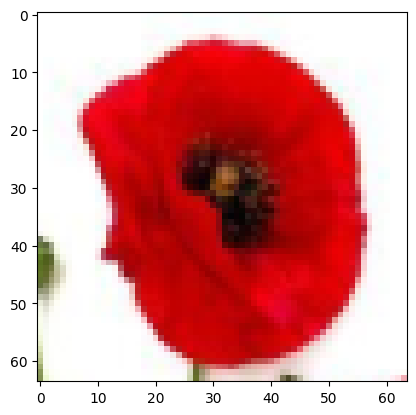

In [22]:
"""
Sprawdźmy, co model sądzi o poniżej wybranym zdjęciu. Wartość 1 oznacza, że jest to mak, wartość 0, że nie.
"""

img = read_image(df_imgs_pass, 32).astype(np.uint8)
print("Czy model to mak? Model odpowiada:", model.predict(np.expand_dims(img, 0)))
plt.imshow(img)

1/1 [==============================] - 0s 28ms/step
Czy model to mak? Model odpowiada: [[0.]]


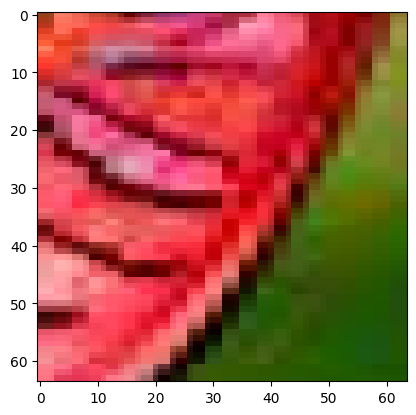

In [23]:
"""
Sprawdźmy ponownie, tym razem dla fragmentu skrzydła motyla:
"""
img = read_image(df_imgs_fail, 10).astype(np.uint8)
print("Czy model to mak? Model odpowiada:", model.predict(np.expand_dims(img, 0)))
plt.imshow(img)

## Test nowego modelu
Gratulacje! W tym momencie otrzymałaś pierwszy prosty model, który umożliwia znalezienie maków na otrzymanych zdjęciach. Sprawdźmy, jak ten model radzi sobie w porównaniu z naszym pierwszym rozwiązaniem, bazującym tylko na kolorze

In [25]:
def detect_poppy(test_img, model, red=0.75, green=0.23, blue=0.23, area_percent=0.002, k_dilate=3):
    
    mask = mask_red_regions(test_img, red, green, blue, area_percent, k_dilate)
    bboxes = get_bboxes_from_mask(mask, increment=0)
    final_bboxes = []
    for bbox in bboxes:
        img_part = test_img[bbox[0]:bbox[1], bbox[2]:bbox[3]]
        res_img = cv2.resize(img_part, img_size, interpolation=cv2.INTER_AREA)
        img_to_tf = np.expand_dims(res_img, axis=0)
#         print(bbox)
        label = model.predict(img_to_tf, verbose=0)
#         print(label)
        if label > 0.5:
            final_bboxes.append(bbox)
    
    return final_bboxes


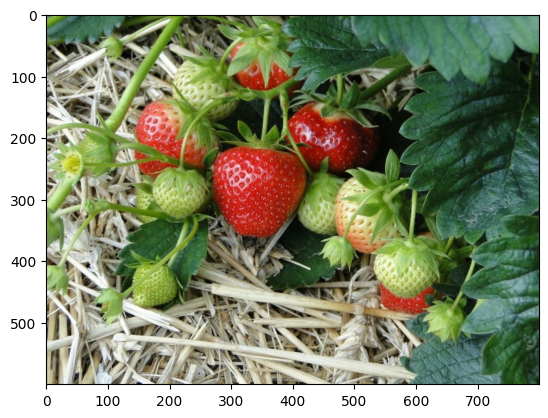

In [31]:
"""
Sprawdźmy, jak model radzi sobie na zbiorze walidacyjnym. Są to zdjęcia o numerach 11-21. Jeśli jesteś ciekawa,
zajrzyj również do zdjęć treningowych. Co tam się zmieniło pod wpływem sieci?
"""
im_num = 16
test_img = read_image(df_test, im_num).astype(np.uint8)
final_bboxes = detect_poppy(test_img, model)
cv_bboxes = convert_bboxes(final_bboxes)
visualise_contours(test_img, cv_bboxes)

Poniżej zamieszczam funkcję, która pozwala na porównanie dwóch sposobów wykrywania zdjęć. Sprawdźmy, jak radzą sobie oba modele:

In [32]:
def models_comparison(df_test, im_num, model):
    test_img = read_image(df_test, im_num).astype(np.uint8)
    cnn_prediction = detect_poppy(test_img, model)
    
    mask = mask_red_regions(test_img, red=0.75, green=0.23, blue=0.23, area_percent=0.002, k_dilate=3)
    vanilla_prediction = get_bboxes_from_mask(mask, increment=0.02)
    
    cnn_bboxes = convert_bboxes(cnn_prediction)
    vanilla_bboxes = convert_bboxes(vanilla_prediction)
    
    vanilla_img = test_img.copy()
    for bbox in vanilla_bboxes:
        draw_img = cv2.drawContours(vanilla_img,[bbox],0,(0,0,255),4)
    
    cnn_img = test_img.copy()
    for bbox in cnn_bboxes:
        draw_img = cv2.drawContours(cnn_img,[bbox],0,(0,0,255),4)
        
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
    ax[0].imshow(vanilla_img)
    ax[0].set_title("reguła z kolorów")
    ax[1].imshow(cnn_img)
    ax[1].set_title("z pomocą sieci neuronowej")   

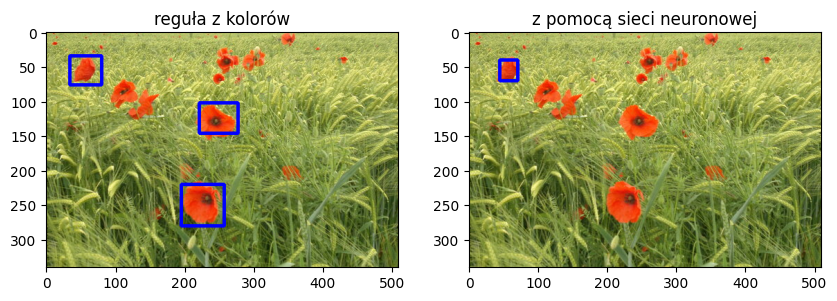

In [34]:
models_comparison(df_test, 19, model)

Jak widzimy, jest znaczna poprawa jeśli chodzi o nie wykrywanie elementów, które nie są makami. Jednak z drugiej strony pogorszyła nam się detekcja samych maków. Jak można poprawić tę sytuację? Można spróbować:
- zwiększyć zbiór treningowy; jednak tym razem sieć uczyła się na niewielu zdjęciach
- używana przez nas sieć jest bardzo mała, co może utrudniać jej dobre nauczenie się reguł. Możemy więc zwiększyć rozmiar sieci neuronowej bądź użyć którejś z sieci pretrenowanych na milionach zdjęć i douczyć ją do naszego zadania
- być może nasze pierwsze wykrycia nie są idealne? Jedną z metod jest użycie kilku tysięcy wycinków o różnych rozmiarach, z których każdy odpowiada innemu regionowi zdjęcia. Takie podejście jest stosowane w przypadku niektórych profesjonalnych rozwiązań, gdzie mała sieć neuronowa uczy się odfiltrowywać potencjalnie ciekawe obszary od tych, na których nie znajduje się nic wartego sklasyfikowania

Potencjalnych ścieżek poprawy detekcji jest wiele, ale te, mam nadzieję, po dzisiejszym ćwiczeniu będziesz sprawdzać sama. Powodzenia w dalszym rozwoju!